2020-04-01 06:22:49
Processing: AHE_3V_IP_RawData.ip


C:\Users\spark\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: divide by zero encountered in true_divide


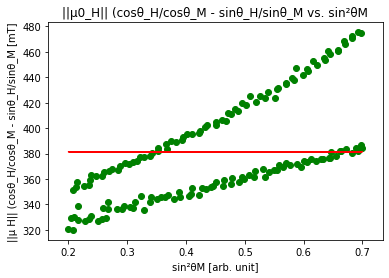

In [21]:
# -*- coding: utf-8 -*-
import os 
import numpy as np
import matplotlib.pyplot as plt
import glob
from tkinter import filedialog as fd
import time
import datetime
from scipy.signal import find_peaks
import math 
from sklearn.linear_model import LinearRegression

###############################################################################
########## Code Body ##########################################################
###############################################################################
    
    
workingPath = fd.askdirectory()
os.chdir(workingPath)

if os.path.isfile("SynthesisFile.txt"):
    os.remove("SynthesisFile.txt")
    
for fileName in sorted(glob.glob("*.IP")):
    st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')  
                 
    #Read the CSV that contains all the data
    currentFile = open(fileName,'r')
    fileLines = currentFile.readlines() 
    fileNameOut = fileName.rstrip(".txt")
    currentFile.close()
    print(st)
    print("Processing: " + fileNameOut)
        
    Field = np.array([])
    hallVolt = np.array([])
    gate_voltage = np.array([])
    theta_M = np.array([])
    sin_theta = np.array([])
    cos_theta = np.array([])
    channel_voltage = np.array([])
    voltage_Counter = 1
    fit = np.array([])
    v_hall = np.array([])

    for lineIndex in range(len(fileLines)):
        currentLine = fileLines[lineIndex]
        dataSegment = currentLine.split()
        Field = np.append(Field, float(dataSegment[9])) #This is milli Tesla
        hallVolt = np.append(hallVolt, float(dataSegment[5])) #This is milli Volt
        channel_voltage = np.append(channel_voltage, float(dataSegment[2])) #This is Volt
        VG = float(dataSegment[6]) - float(dataSegment[2])/2
        gate_voltage = np.append(gate_voltage, np.round(VG, 2)) #This is Volt
        if lineIndex > 1 and VG != gate_voltage[lineIndex-1]:
            voltage_Counter = voltage_Counter + 1

    #for i in range(len(gate_voltage)) ##this line is written by my mentor
        #newcoloum = 

    #for i in range(len(gate_voltage)):
        #for iteration in range(voltage_Counter):
     #   VGate = 

    HV = hallVolt-((max(hallVolt))+min(hallVolt))/2
    # Split up field array as well ()  ##this line is written by my mentor
    HVN = HV/((max(HV)-min(HV))/2)
    

    for index in range(len(HVN)):
        if HVN[index] < 0:
            theta_M = np.append(theta_M, math.acos(HVN[index])-np.pi)
        else:
            theta_M = np.append(theta_M, math.acos(HVN[index]))

    for angle in range(len(theta_M)):
        sin_theta = np.append(sin_theta, math.sin(theta_M[angle]))
        cos_theta = np.append(cos_theta, math.cos(theta_M[angle]))

    #From here on issues in code

    x = sin_theta ** 2
    RHS = abs(Field * ((math.cos(86*np.pi/180)/cos_theta) - (math.sin(86*np.pi/180)/sin_theta)))
    array = np.column_stack([x, RHS, gate_voltage])
    
    xFit = np.array([])
    RHSFit = np.array([])
    x_new = []
    RHS_new = []
    
    for a,b,c in array:
        if c == 3: # change specific gate_voltage value
            x_new.append(a)
            RHS_new.append(b)
    x_new = np.array(x_new)
    RHS_new = np.array(RHS_new)
    for index in range(len(x_new)):
        if x_new[index] > 0.2 and x_new[index] < 0.7:
            xFit = np.append(xFit, x_new[index])
            RHSFit = np.append(RHSFit, RHS_new[index])
    
    model = LinearRegression().fit(xFit.reshape(-1,1), RHSFit)
    regression_line = xFit*model.coef_ + model.intercept_

    m = (((np.mean(xFit) * np.mean(RHSFit)) - np.mean(xFit*RHSFit)) / (np.mean(xFit)**2 -np.mean(xFit*RHSFit)))
    b = np.mean(RHSFit) - m*np.mean(xFit)
    regression_line = xFit*m + b

#     plt.figure(1)
#     plt.plot(Field, HV)
#     # plt.plot(Field, HV, label= "VG = " + str(VGate))
#     figureName = '01. hall voltage.png'
#     plt.title("hall voltage vs. Field")
#     plt.legend()
#     plt.xlabel("Field [mT]")
#     plt.ylabel("HallVolt [mV]")
#     plt.savefig(os.path.join(workingPath, figureName), dpi = 200, format = 'png')
#     plt.show()
#     plt.close(1)

#     plt.figure(2)   
#     plt.plot(Field, HVN)
#     figureName = '02. nomralized hall voltage.png'
#     plt.title("Normalized hall voltage vs. Field")
#     plt.xlabel("Field [mT]")
#     plt.ylabel("HallVolt [mV]")
#     plt.savefig(os.path.join(workingPath, figureName), dpi = 200, format = 'png')
#     plt.show()
#     plt.close(2)

#     plt.figure(3)
#     plt.plot(Field, theta_M)
#     figureName = '03. IP magnetization curve.png'
#     plt.title("In-plane curve")
#     plt.xlabel("Field [mT]")
#     plt.ylabel("theta_M [°]")
#     plt.savefig(os.path.join(workingPath, figureName), dpi = 200, format = 'png')
#     plt.show()
#     plt.close(3)

    plt.figure(4)
    plt.scatter(xFit, RHSFit, c = 'green')
    plt.plot(xFit, regression_line, c = 'r')
    figureName = '04. RHS vs LHS.png'
    plt.title("||µ0_H|| (cos\u03B8_H/cos\u03B8_M - sin\u03B8_H/sin\u03B8_M vs. sin²\u03B8M")
    plt.xlabel("sin²\u03B8M [arb. unit]")
    plt.ylabel("||\u03BC H|| (cos\u03B8_H/cos\u03B8_M - sin\u03B8_H/sin\u03B8_M [mT]")
    plt.savefig(os.path.join(workingPath, figureName), dpi = 200, format = 'png')
    plt.show()
    plt.close(4)


#     dataFile = fileNameOut + "-Raw.txt"
#     with open(os.path.join(workingPath, dataFile),'w') as temp_file:
#         temp_file.write('Field [mT]' + '\t' + 'Hall Voltage [mV]' +'\t' + 'Gate Voltage [V]' + '\n')
#         for index in range(len(gate_voltage)):
#             temp_file.write(str(Field[index]) + '\t' + str(HV[index]) +  '\t' + str(gate_voltage[index]) + '\n')
    
#     with open("SynthesisFile.txt",'a') as temp_file:
#         temp_file.write("-------------------------------------------------------\n")
#         temp_file.write(st + "\n")
#         temp_file.write('Data from measurement: ' + fileNameOut + '\n')
#         temp_file.write("-------------------------------------------------------\n")

In [13]:
np.unique(gate_voltage)

array([-3. , -1.5, -0. ,  1.5,  3. ])

In [15]:
dup = np.unique(gate_voltage)
for i in dup:
    print(i)

-3.0
-1.5
-0.0
1.5
3.0


In [ ]:
RHSFit.shape

In [12]:
regression_line

array([403.03929676, 403.03910234, 403.03885655, 403.03867926,
       403.03831148, 403.03816465, 403.03789402, 403.03767705,
       403.03740246, 403.03703948, 403.03690013, 403.03660784,
       403.03626155, 403.03589943, 403.0357714 , 403.035516  ,
       403.03516693, 403.03492219, 403.03461751, 403.03438001,
       403.03398805, 403.03372921, 403.03346307, 403.03311307,
       403.03295301, 403.03264593, 403.03238606, 403.03221699,
       403.03193241, 403.03149674, 403.03124099, 403.03107968,
       403.0307724 , 403.03060712, 403.03026573, 403.03000808,
       403.02969568, 403.02948721, 403.02923807, 403.02899628,
       403.02917686, 403.02949064, 403.02973756, 403.02998202,
       403.0301351 , 403.030559  , 403.03076697, 403.0309485 ,
       403.03114809, 403.03145998, 403.03181781, 403.03204406,
       403.03222692, 403.03269728, 403.03276986, 403.03321502,
       403.03342029, 403.0336118 , 403.03405936, 403.03415515,
       403.03450693, 403.03486881, 403.03494612, 403.03

In [10]:
regression_line

array([388.80887431, 388.80877901, 388.80843458, 388.80820028,
       388.80793353, 388.80771145, 388.80741965, 388.80708564,
       388.80679802, 388.8065403 , 388.80627963, 388.80598616,
       388.80568645, 388.80555756, 388.80519992, 388.80492122,
       388.80448438, 388.80430695, 388.80399286, 388.80368298,
       388.80341887, 388.80308647, 388.80292514, 388.80240592,
       388.80232047, 388.80191482, 388.801631  , 388.80136358,
       388.80107973, 388.80096033, 388.80057926, 388.80023851,
       388.80001199, 388.79964288, 388.79939618, 388.7991519 ,
       388.79891276, 388.79860578, 388.79834963, 388.79843104,
       388.79862346, 388.79884252, 388.79909753, 388.79937382,
       388.79972566, 388.80001962, 388.8001367 , 388.80050021,
       388.80073655, 388.80100966, 388.80132436, 388.80166402,
       388.80190011, 388.80215894, 388.80247824, 388.80278218,
       388.80296618, 388.80331991, 388.803557  , 388.80391041,
       388.80413822, 388.80448654, 388.80467333, 388.80

In [ ]:
gate_voltage.shape

In [ ]:
x_new.shape